# Imports:

In [46]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport 

%matplotlib inline
sns.set()

from math import ceil

# Reading the Data:

In [47]:
df = pd.read_csv('donors.csv', header=0, index_col=[0,'CONTROLN'], low_memory=False, 
                 dtype={'TCODE':'str','HPHONE_D':'str','RFA_2F':'str','WEALTH1':'str','WEALTH2':'str','INCOME':'str'})
# I´m setting low_memory=False because of the warming related to the dtype of some variables;
# **Because the variable 'CONTROLN' refers to the unique record identifier so it´s unique for each donor, we´ll also set it has 
# index;
# I´m changing the dtype of the above variables so it gets easier to identify the metric features later on in my notebook;
# meti HPHONE_D como str pq é 'categorica', já está sob a forma de 0´s e 1´s
# meti Wealth1 e wealth2 como str tbm por serem categoricas
df.head()

,,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
0,95515,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,4.0,7.741935,0,L,4,E,X,X,X,C
1,148535,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,18.0,15.666667,0,L,2,G,X,X,X,A
2,15078,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,12.0,7.481481,1,L,4,E,X,X,X,C
3,172556,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,9.0,6.812500,1,L,4,E,X,X,X,C
4,7112,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,14.0,6.864865,1,L,2,F,X,X,X,A


### Making a copy of our original dataset:

In [48]:
df_original = df.copy()

# Data initial analysis + Possible problems:

In [4]:
# replace "" by nans:
df.replace("", np.nan, inplace=True)

In [5]:
# check df data types:
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE       object
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 474, dtype: object

In [6]:
# checking descriptive statistics:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ODATEDW,95412,54,2015-01-01,15358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OSOURCE,95412,896,MBC,4539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCODE,95412,55,0,40917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE,95412,57,CA,17343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP,95412,19938,85351,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
RFA_2A,95412,4,F,46964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MDMAUD_R,95412,5,X,95118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MDMAUD_F,95412,4,X,95118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MDMAUD_A,95412,5,X,95118,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# sorted count of missing values:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)

RDATE_5     95403
RAMNT_5     95403
RDATE_3     95170
RAMNT_3     95170
RDATE_4     95131
            ...  
MSA           132
ADI           132
DMA           132
GEOCODE2      132
FISTDATE        2
Length: 92, dtype: int64

In [8]:
# Define/update metric and non-metric features:
def update_metric_feat(df):
    metric_features = []
    non_metric_features = []
    for feat in df.columns:
        if (df[feat].dtype =='O'):
            non_metric_features.append(feat)
        else:
            metric_features.append(feat)
    return metric_features,non_metric_features

metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

#### -> Exploring a sample of this dataset using pandas-profiling report 

We are generating the report from only a part of the data we have. (this sample needs to be representative of our data)

In this case we wil randomize the order of the data and select a representative sample.

In [9]:
# # forming ProfileReport from our sample of ___ random donors 
# # (!!!tentar outras alternativas p/ fazer a sample, ex: Cluster Sampling!!!):
# profile = ProfileReport(df.sample(n=10000), minimal=True) 

# # # saving the report as an output.html file 
# profile.to_file("output.html")

# Data Pre-processing:

#### -> Remove features with a great value of missing values (more than 50% of missing values)

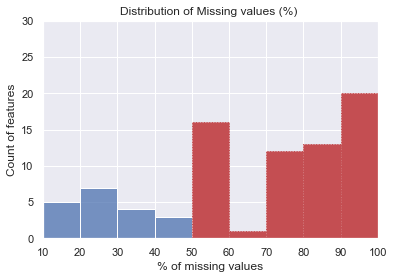

In [10]:
# Plotting the distribution of missing values(greater than 10%)
ax = sns.histplot(df.isnull().mean()*100, bins='auto')
ax.set_title('Distribution of Missing values (%) ')
ax.set(xlabel='% of missing values', ylabel='Count of features',xlim=(10,100),ylim=(0,30))
# Colloring red the bars that represent the count of features with % of missing values >= 50% :
for i in range(5,10):
    ax.patches[i].set_color('r')
    ax.patches[i].set_linestyle(':')
plt.show(ax)

In [11]:
# Listing the features with more than 50% of NAN´s
cols = df.columns[df.isnull().mean() > 0.5]
print('Columns with more than 50% of missing values:\n',cols)
df = df.drop(cols, axis=1)

# From the group of variables 'ADATE_2'-'ADATE_24', we deleted some variables based on the amount of missing values, and 
# it doesn´t make sense to drop some and keep the others, hence the next step:
cols = df.loc[:,'ADATE_2':'ADATE_24'].columns
df.drop(cols, axis=1,inplace=True)

# updating metric and non metric features list:
metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

Columns with more than 50% of missing values:
 Index(['NUMCHLD', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML',
       'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY',
       'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'ADATE_15', 'ADATE_20', 'ADATE_23',
       'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', 'RAMNT_3', 'RAMNT_4',
       'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10',
       'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16',
       'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22',
       'RAMNT_23', 'RAMNT_24'],
      dtype='object')


#### -> Aqui fazer uns boxplots para visualizar os outliers:

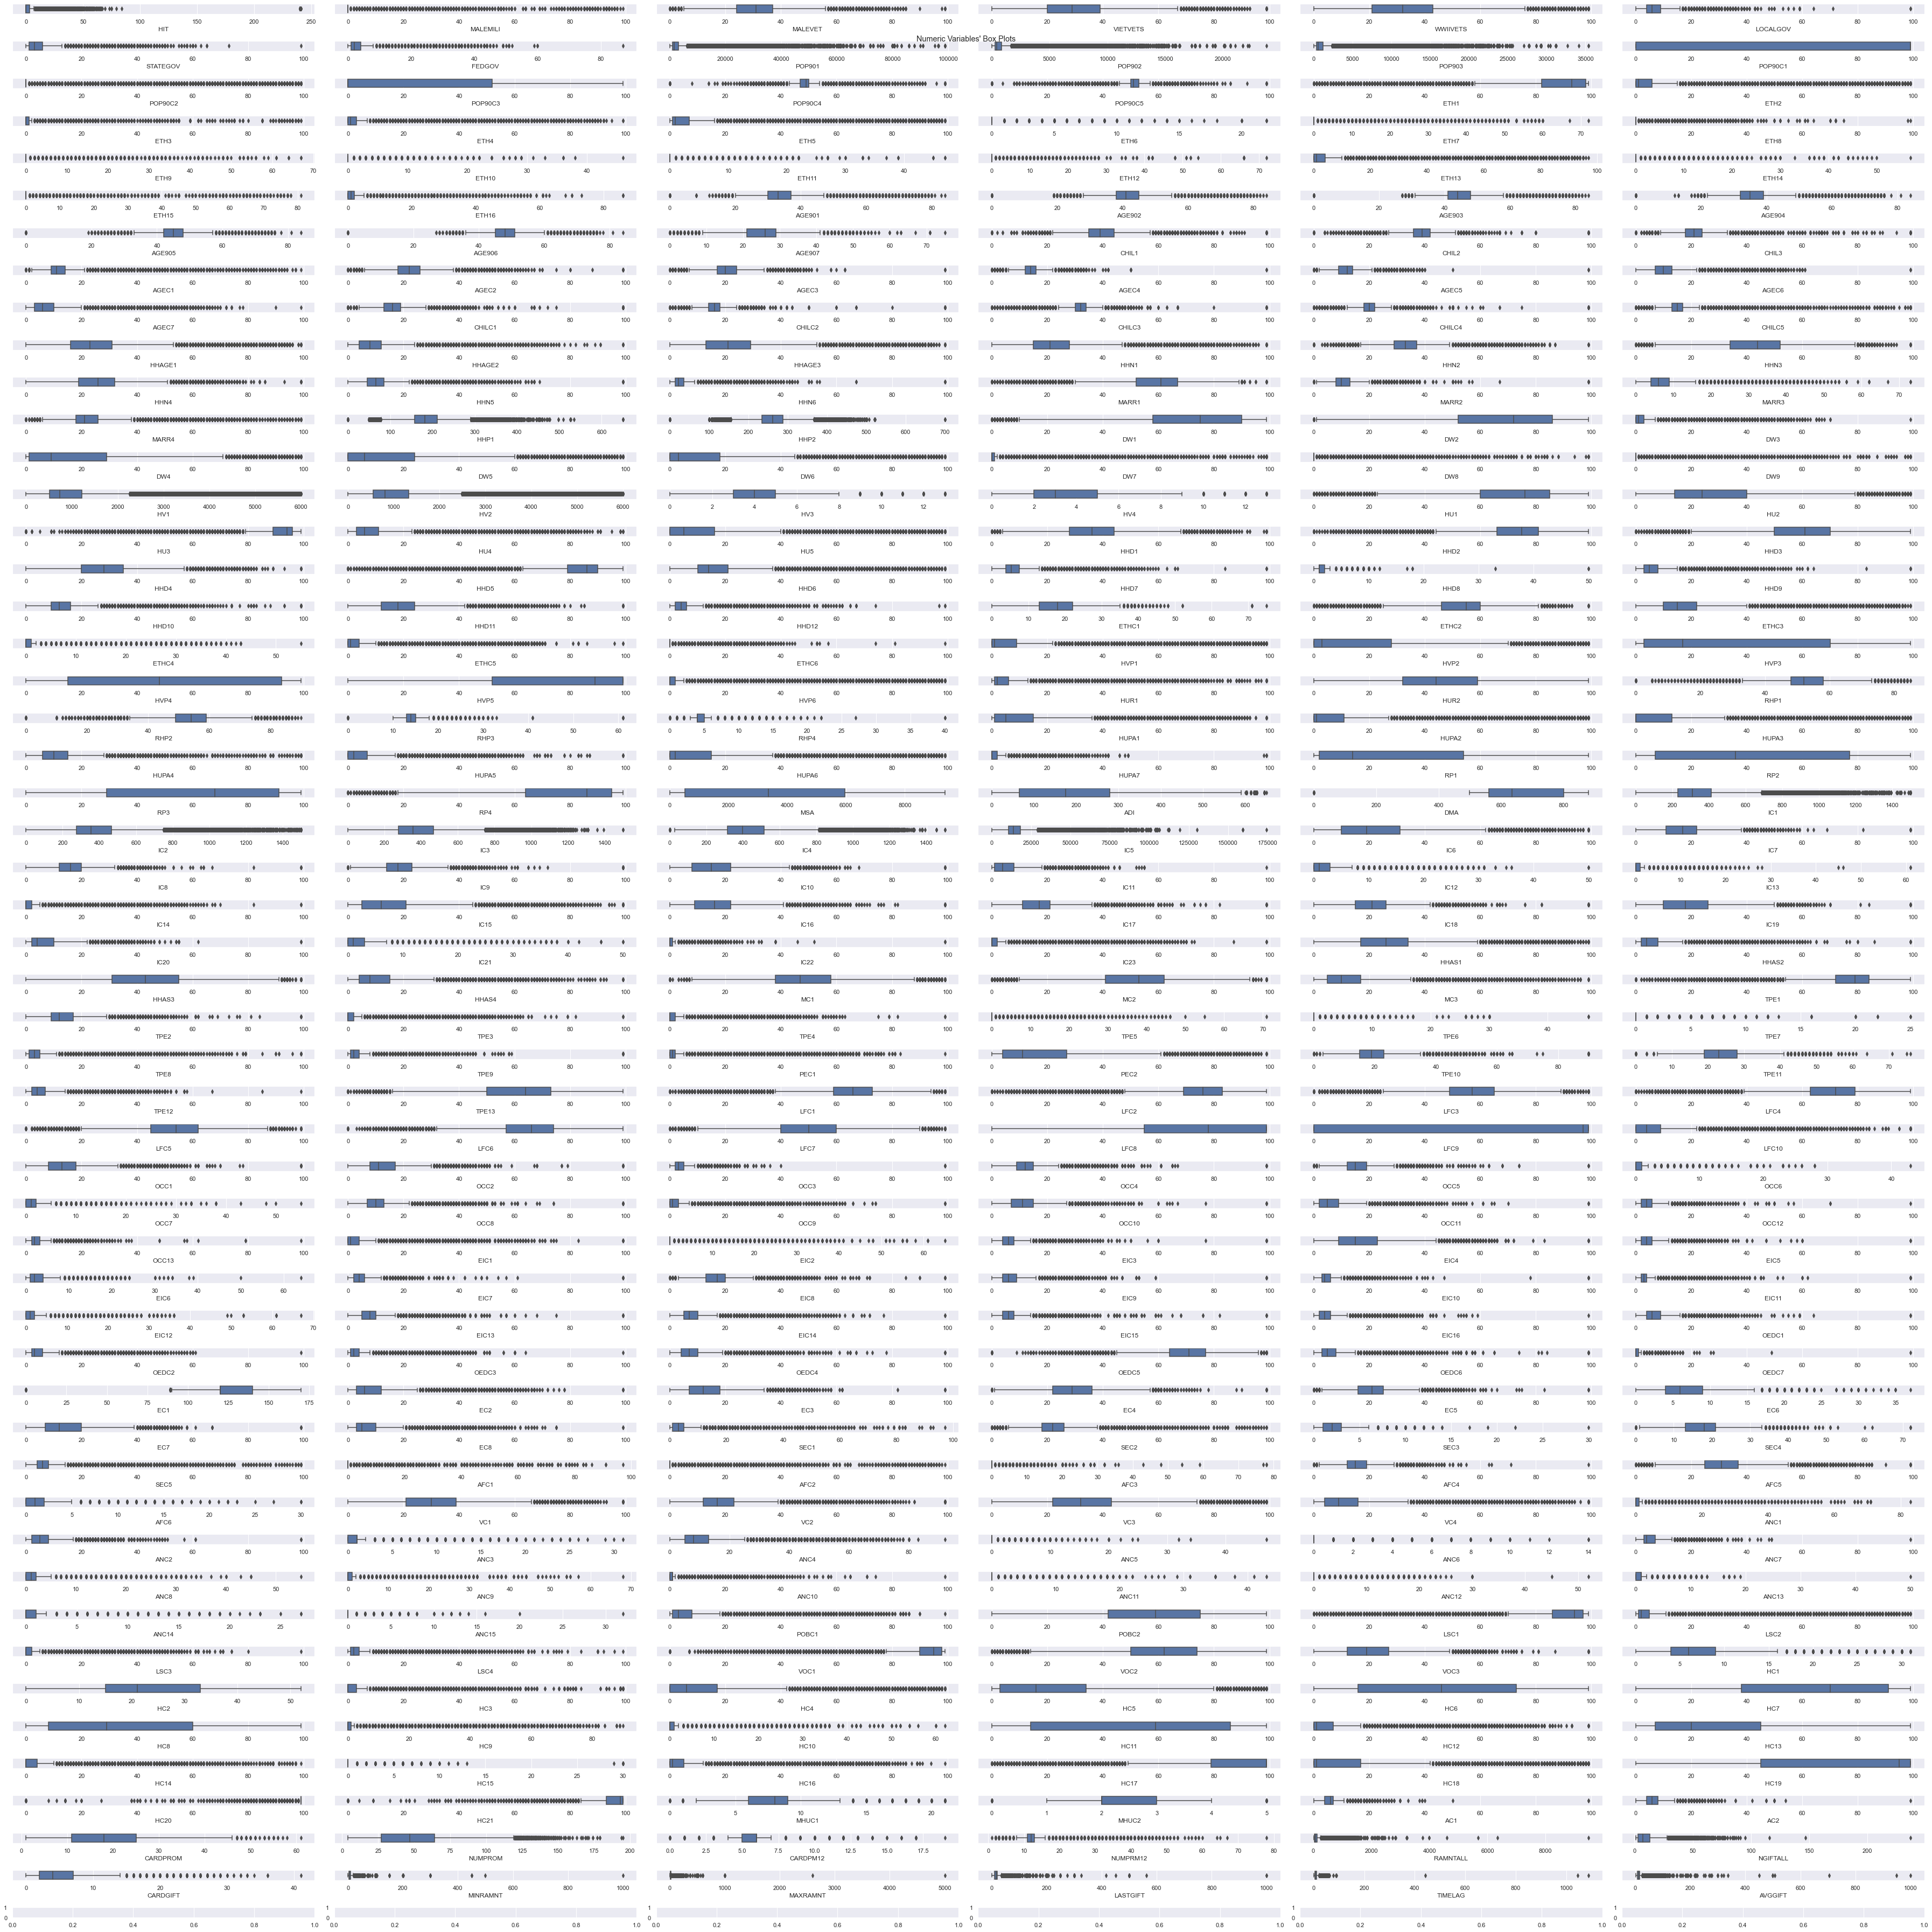

In [12]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(52, ceil(len(metric_features) / 52), figsize=(50, 50), squeeze=True)

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
#     ax.set_title(feat, y=-0.21)

# Adjusting my subplots:
fig.tight_layout()

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)

plt.show()

### ->  !!!Outlier removal!!! -> ver outro método!!!! (este elimina mto!)

In [13]:
# Defining a function that removes the outliers from the metric features, using the IQR method:
def remove_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = (q3 - q1) 
    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr
    df_no_outliers = df.loc[(df[col_name] >= lower_lim) & (df[col_name] <= upper_lim)].copy()
    # Variable that indicates the amount removed in this column:
    num_rows_removed = df.shape[0] - df_no_outliers.shape[0]
    return df_no_outliers,num_rows_removed

# REMOVENDO OS OUTLIERS DE TODAS AS FEATURES:
# # Aqui estou a remover os outliers e a fazer a soma do nº de observações eliminadas para ver se 
# # está abaixo dos 3% da nossa data:
# soma=0
# new_df = df.copy()
# for feat in metric_features:
#     func = remove_outliers(new_df, feat)
#     new_df = func[0]
#     soma+=func[1]
# print('sum of deleted rows:',soma)
# print('% eliminated: ',soma/df.shape[0])

#### Célula para testar a nossa funçao remove_outliers:

In [14]:
# # Transforming 'DOB', which contains the day,month and year of birth in a way that only contains the
# # year of birth, so that we don´t have as many unique values, and transforming it into an integer value:

# df['DOB'] = df['DOB'].apply(lambda x: int(str(x)[:4]) if (str(x)!='nan') else None)
# remove_outliers(df, 'DOB')[0]['DOB'].value_counts()
# print('% eliminated: ',remove_outliers(df, 'DOB')[1]/df.shape[0]*100)

# updating metric and non metric features list:
metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

### -> !!!! Imputation of the missing values!!!! (both of the numerical and categorical features) :

In [15]:
# Filling in the missing values, for the categorical/ordinal features, with the mode: 
for feat in non_metric_features:
    df[feat].fillna(df[feat].value_counts().index[0],inplace=True)

In [16]:
# Seeing rows with NaNs
nans_index = df.isna().any(axis=1)
df[nans_index]

,,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
10,106016,2016-01-01,AGR,0,KS,67335,,,1968-01-01,0,,...,NaN,20.0,0,L,1,F,X,X,X,D
21,72675,2016-01-01,L21,1,MI,49247,,,1936-01-01,0,,...,NaN,25.0,1,L,1,G,X,X,X,C
26,89160,2016-01-01,ESN,0,IL,60091,,,1976-01-01,0,,...,NaN,50.0,0,L,1,G,X,X,X,A
36,127328,2015-01-01,AIR,1,TX,78748,,,1949-01-01,0,,...,NaN,25.0,1,L,1,G,X,X,X,B
60,123388,2016-01-01,BOA,0,TX,77515,,,1984-01-01,0,,...,NaN,23.0,1,L,1,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95381,57442,2016-01-01,GET,1,KY,40517,,,1968-01-01,0,,...,NaN,20.0,1,L,1,F,X,X,X,B
95384,126131,2016-01-01,ADD,0,TX,78418,,,1968-01-01,0,,...,NaN,20.0,0,L,1,F,X,X,X,B
95392,132458,2015-01-01,MBC,1,CO,80480,,,1968-01-01,0,,...,NaN,25.0,0,L,1,G,X,X,X,D


In [17]:
# # (alternativa1-demora algum tempo) KNNImputer - To Fill in the missing values, For the numerical varibles:
# imputer = KNNImputer(n_neighbors=5, weights="uniform")
# df[metric_features] = imputer.fit_transform(df[metric_features])

# (alternativa 2-> fill missing values with the median value)
from sklearn.impute import SimpleImputer
imputer_median = SimpleImputer(missing_values=np.NaN, strategy='median')
df[metric_features] = imputer_median.fit_transform(df[metric_features])

# See rows with NaNs imputed
df.loc[nans_index, metric_features]

,,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,...,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
10,106016,0.0,0.0,38.0,31.0,46.0,6.0,5.0,2.0,3356.0,922.0,...,5.0,12.0,20.0,1.0,1.0,20.0,20.0,20.0,6.0,20.0
21,72675,0.0,0.0,28.0,36.0,20.0,9.0,3.0,1.0,1112.0,327.0,...,5.0,11.0,25.0,1.0,1.0,25.0,25.0,25.0,6.0,25.0
26,89160,0.0,0.0,32.0,10.0,54.0,8.0,0.0,4.0,1666.0,523.0,...,5.0,11.0,50.0,1.0,1.0,50.0,50.0,50.0,6.0,50.0
36,127328,1.0,3.0,36.0,55.0,16.0,11.0,17.0,7.0,2153.0,646.0,...,4.0,10.0,25.0,1.0,0.0,25.0,25.0,25.0,6.0,25.0
60,123388,1.0,0.0,47.0,56.0,24.0,8.0,9.0,2.0,996.0,274.0,...,5.0,12.0,23.0,1.0,0.0,23.0,23.0,23.0,6.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95381,57442,0.0,0.0,25.0,47.0,17.0,5.0,8.0,4.0,5358.0,1427.0,...,4.0,10.0,20.0,1.0,1.0,20.0,20.0,20.0,6.0,20.0
95384,126131,4.0,10.0,27.0,17.0,61.0,3.0,0.0,4.0,630.0,204.0,...,4.0,11.0,20.0,1.0,1.0,20.0,20.0,20.0,6.0,20.0
95392,132458,0.0,0.0,36.0,24.0,35.0,9.0,3.0,3.0,1605.0,454.0,...,4.0,10.0,25.0,1.0,1.0,25.0,25.0,25.0,6.0,25.0


In [18]:
# Checking that we don´t have missing values anymore:
df.isnull().sum()

ODATEDW     0
OSOURCE     0
TCODE       0
STATE       0
ZIP         0
           ..
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
GEOCODE2    0
Length: 392, dtype: int64

## Feature Selection:

#### -> Function that plots an heatmap of the correlation matrix passed as input:

In [19]:
def corr_heatmap(corr):    
    # Prepare figure
    fig = plt.figure(figsize=(50, 30))
    # Build annotation matrix (values above |0.8| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= 0.8
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))
    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot_kws={"size": 10})
    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)
    plt.show()

#### -> Function that plots Histograms of a set of variables:

In [20]:
def histograms(df,features, bins=10,figsize=(15, 8)):
    # Put this Variables' Histograms in one figure
    sns.set()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(ceil(len(features) / 4),4, figsize=figsize)

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], bins=bins)
        ax.set_title(feat, y=-0.17)

    # Layout
    # Add a centered title to the figure:
    title = "Variables' Histograms"
    plt.suptitle(title)
    plt.show()

### Numerical features:

#### -> Drop features with low variance (Because these features don´t vary almost anything) within different donnors. 
#### Done on a scaled data using MinMax so we can use a threshold value for the std (of 0.03) regardless of the scale of the variable.
-> These variables are redundant, so doesn´t make sense to include them in our analysis.


-low variance features don´t give us much information
-> we will calculate the variance of each feature, then drop features with variance below some threshold


In [21]:
# Scalling our data:
scaler = MinMaxScaler()
# transform data:
scaled = scaler.fit_transform(df[metric_features])
scaled = pd.DataFrame(scaled,columns=metric_features)

In [1]:
low_variance_features = []
for feature in metric_features:
    if (scaled[feature].std())<0.03:
        low_variance_features.append(feature)

print('The following are redundant variables because of their low variance:\n',low_variance_features)

#Plotting an histogram of those variables:
histograms(df,low_variance_features, bins='auto',figsize=(35, 50))

# Dropping (note: I wont drop the boolean variable HPHONE_D because it only takes 0 and 1 values so it will easily have a std 
# value above my threshold, but I won´t consider it has being redundant):
df.drop(columns=low_variance_features, inplace=True)

#updating metric features list:
metric_features = update_metric_feat(df)[0]

NameError: name 'metric_features' is not defined

#### -> ??Remover os q têm variancia mto alta tbm??

#### -> Remove the features that have high correlation values (threshold of 80%) -> To avoid multicolinearity
For each pair of correlated features, our method identifies one of the features for removal (because we only need to remove one of them)

Make visualization with the high correlations (ex:heatmap that shows all the features that have at least one correlation above the threshold)

Make list of correlated features that will be removed, or show the highly correlated pairs of features in a dataframe

The features to be removed because of their high correlation are:
 ['POP902', 'POP903', 'ETH13', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGEC6', 'CHILC1', 'CHILC3', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR3', 'HHP1', 'HHP2', 'DW2', 'DW5', 'DW6', 'HV2', 'HV4', 'HU2', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD9', 'HHD11', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'RHP1', 'RHP2', 'RHP3', 'HUPA2', 'HUPA5', 'HUPA6', 'RP1', 'RP2', 'RP3', 'RP4', 'IC2', 'IC3', 'IC4', 'IC5', 'IC11', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC23', 'HHAS1', 'HHAS4', 'MC2', 'TPE4', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'EIC1', 'OEDC1', 'OEDC2', 'OEDC3', 'SEC4', 'AFC2', 'AFC5', 'LSC2', 'LSC3', 'VOC2', 'VOC3', 'HC5', 'HC6', 'HC7', 'HC8', 'HC18', 'HC21', 'NUMPROM', 'CARDGIFT']


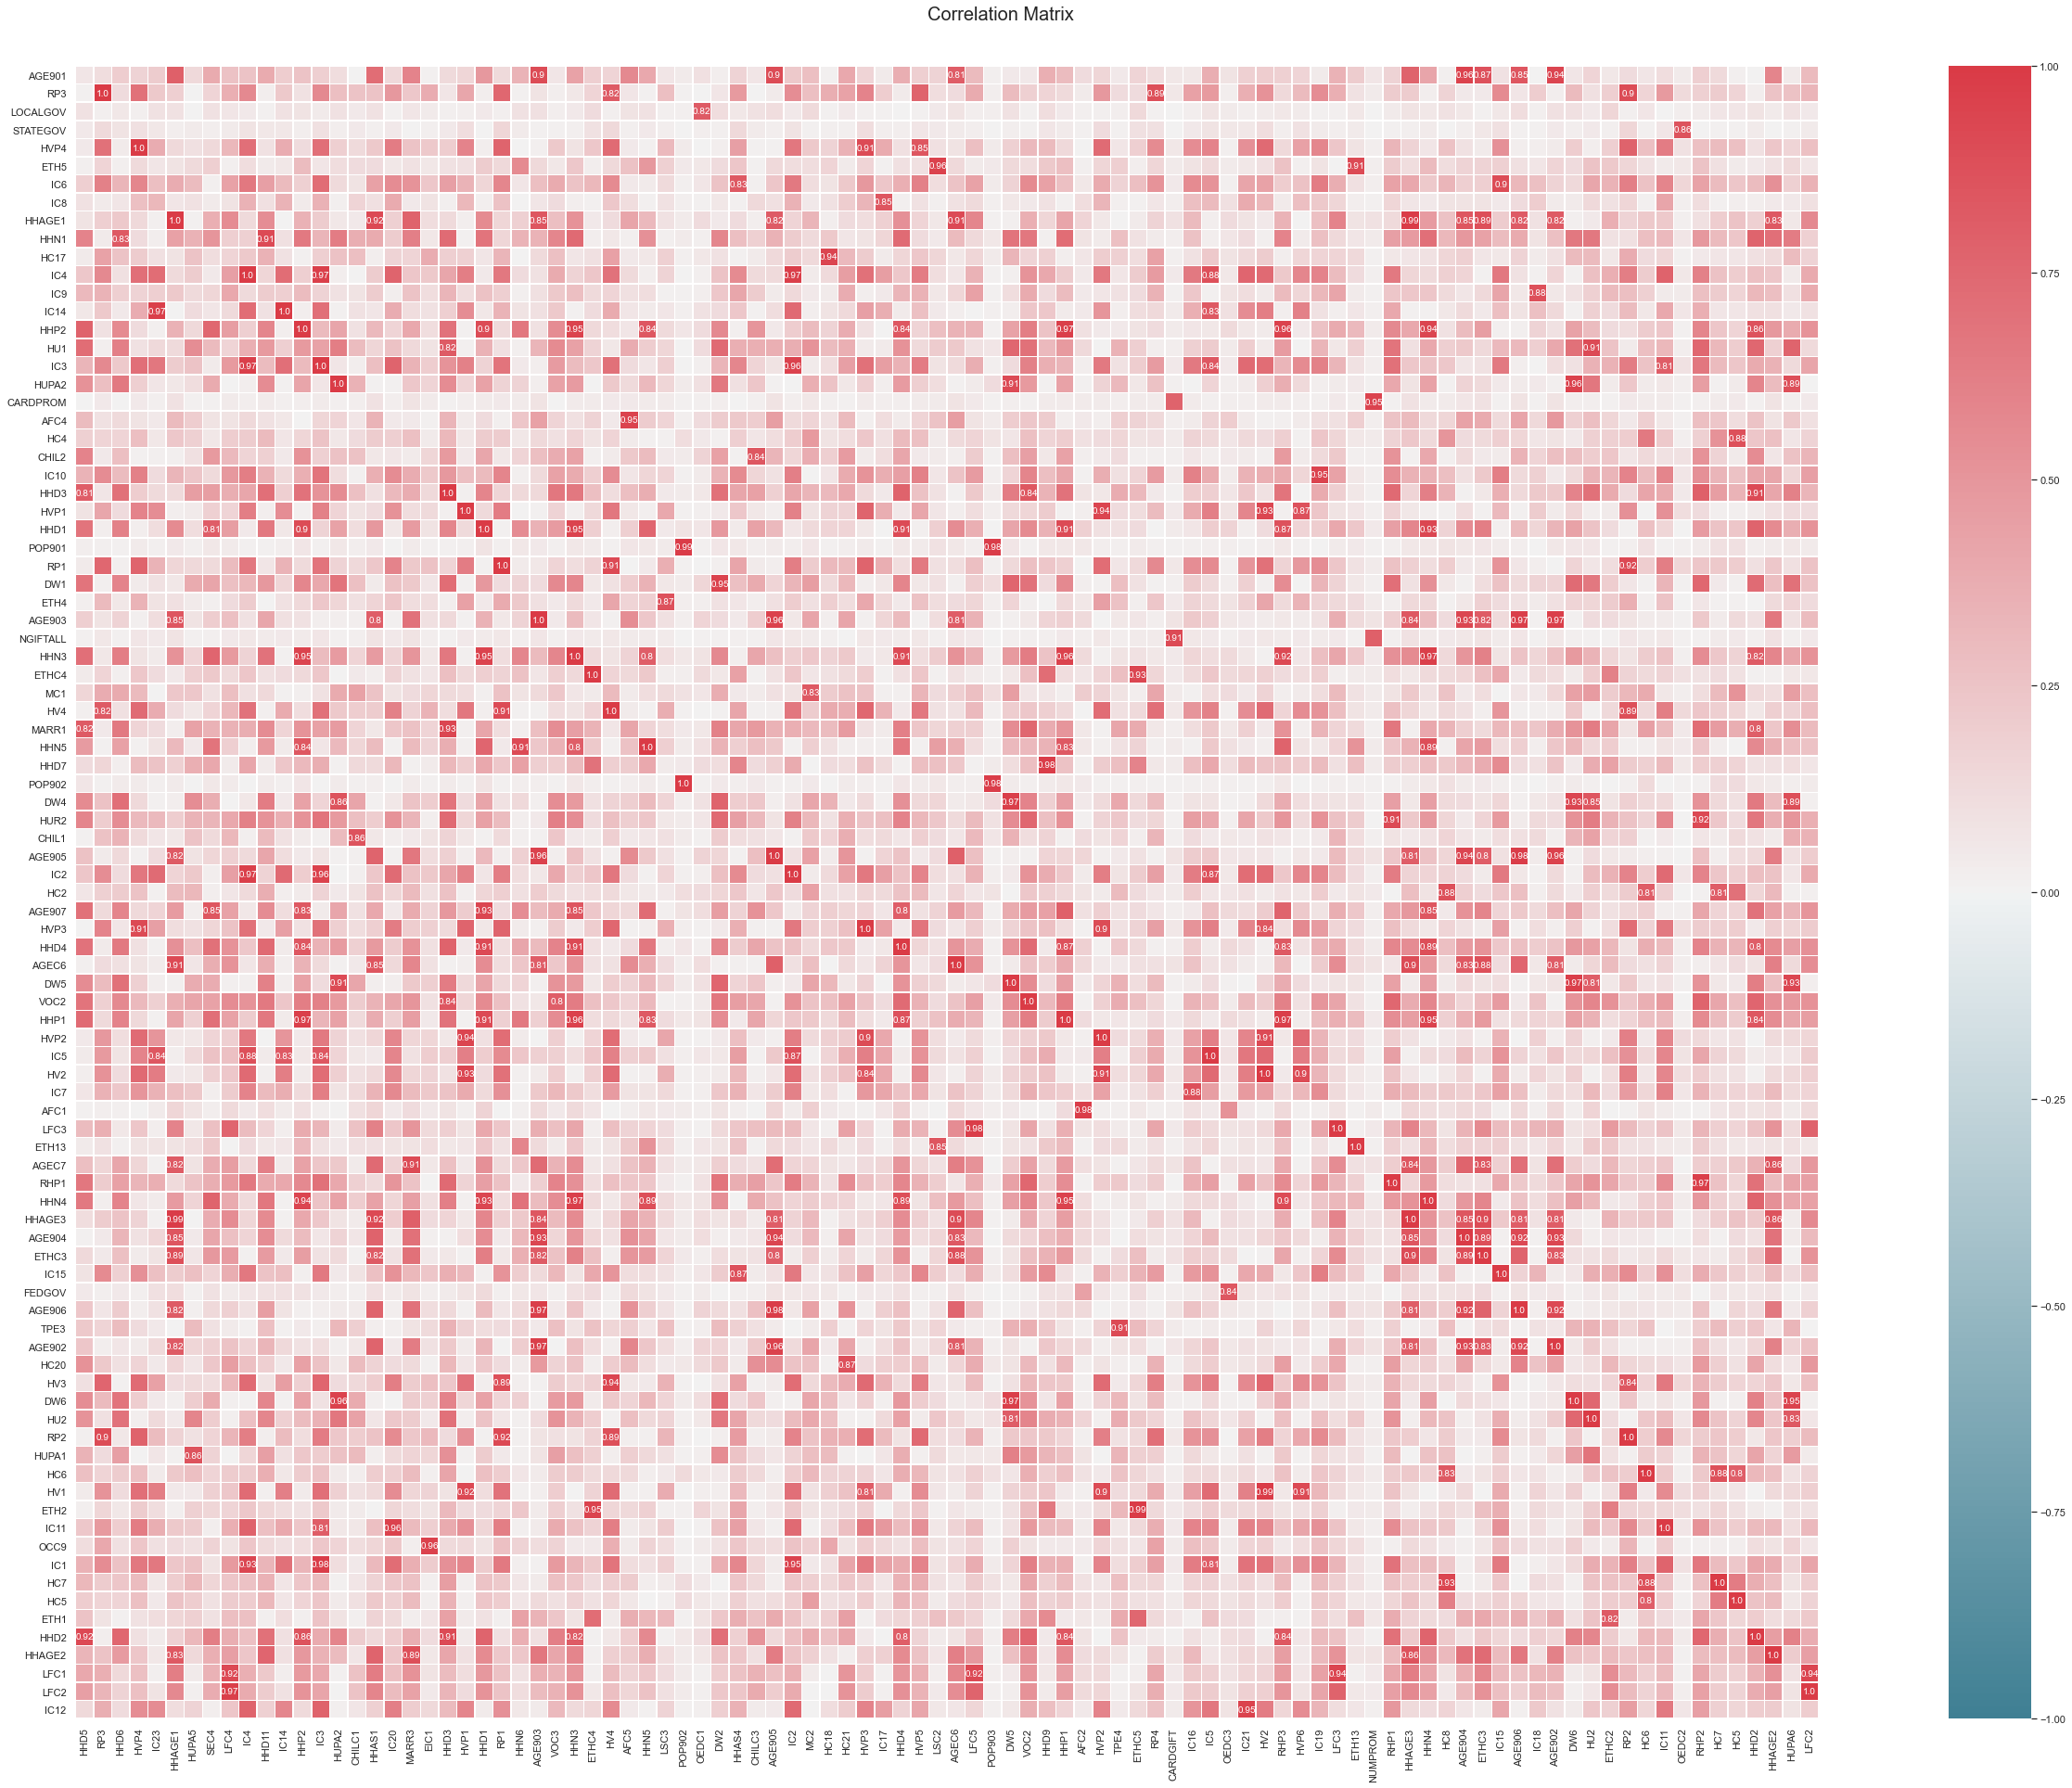

In [23]:
# Creating correlation matrix with the absolute values of the corr:
corr = df.corr().abs()

# Selecting upper triangle of the correlation matrix:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Finding the index of the feature's columns with correlation greater than 0.80 (>=very strong correlation)
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

print('The features to be removed because of their high correlation are:\n',to_drop)

# Saving the pairs of correlated features so I can plot an heatmap of their correlations:

# I´ll save both the dropped feature and the one that was correlated with it:
records = pd.DataFrame(columns = ['dropped_feat', 'corr_feat'])
for column in to_drop:
    corr_features = list(upper.index[upper[column].abs() > 0.8])
    drop_features = [column for _ in range(len(corr_features))]
    # Record the information (need a temp df for now)
    aux_df = pd.DataFrame.from_dict({'dropped_feat': drop_features,'corr_feat': corr_features})

    # Add to dataframe
    records = records.append(aux_df, ignore_index = True)


corr_matrix_plot = corr.loc[list(set(records['corr_feat'])),list(set(records['dropped_feat']))]
title = "Correlations Above Threshold"
# * the features on the x axis are the ones that are going to be removed


# Plotting an heatmap:
corr_heatmap(np.round(corr_matrix_plot,decimals=2))


# Dropping the highly correlated features 
df.drop(columns = to_drop, inplace=True)

# updating metric features list:
metric_features = update_metric_feat(df)[0]

#### -> PCA

### Categorical Features:

Fazer uns plots, como barcharts e pieplots!

#### -> I´ll remove the variables that for one category have more than 90% of the observations:

In [24]:
to_drop=[]
for feature in non_metric_features:
    for proportion in df[feature].value_counts()/len(df):
        if proportion > 0.90:
            to_drop.append(feature)
            break

print('The non metric features that have more than 90% in one of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have more than 80% in one of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'SOLP3', 'SOLIH', 'MAJOR', 'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'MAXADATE', 'RFA_2R', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']


#### -> Pieplots:

In [25]:
# import plotly.express as px
# from plotly.subplots import make_subplots

# # Prepare figure. Create figures where each pieplot will be placed
# # use 'domain' type for Pie subplot
# for feat in non_metric_features:
#     fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
#     fig=px.pie(df[feat], names=feat, title=feat)
#     fig.show()

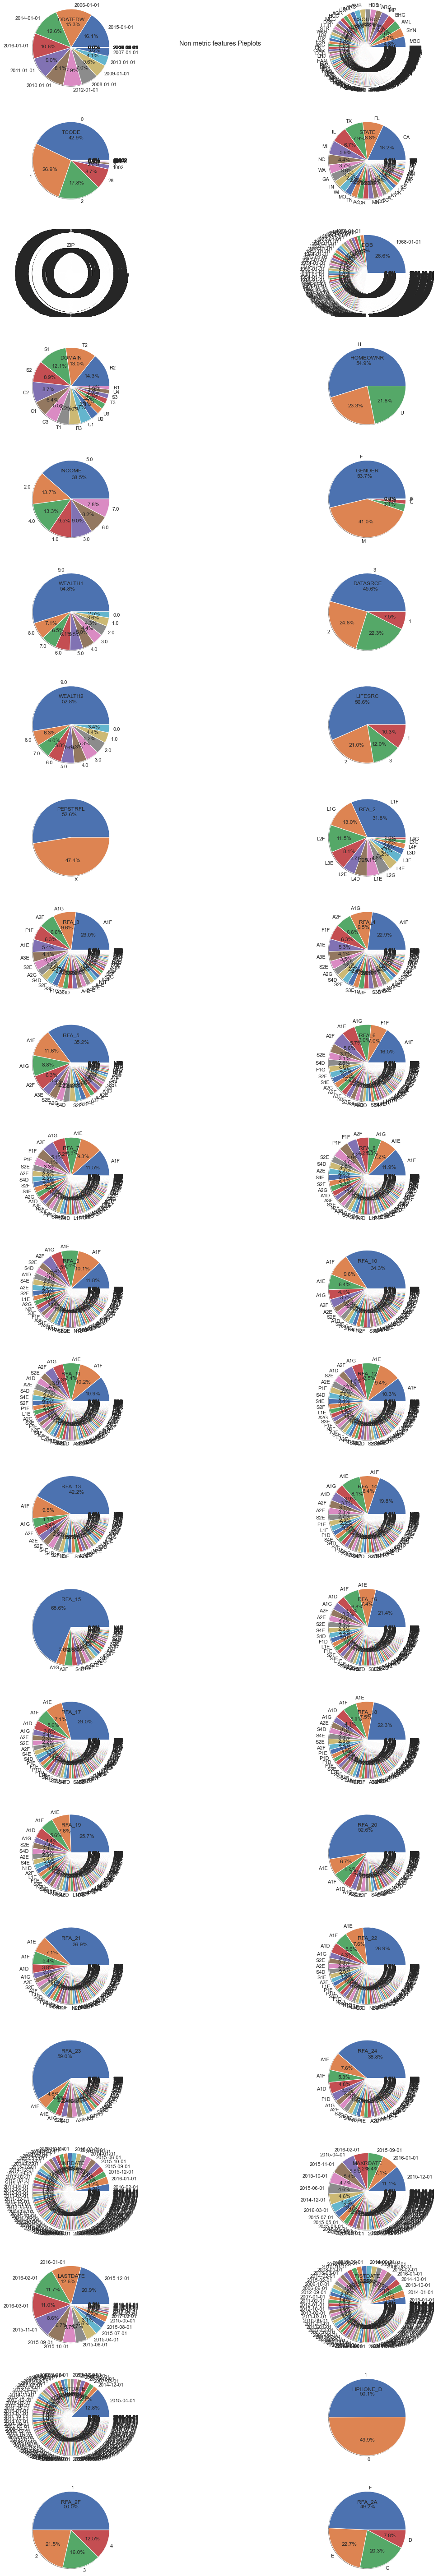

In [26]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(23, 2, figsize=(20, 80))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.pie(df[feat].value_counts().values,labels=df[feat].value_counts().index,autopct='%1.1f%%', shadow=True, radius=2)
    ax.set_title(feat)
fig.tight_layout()
# Layout
# Add a centered title to the figure:
title = " Non metric features Pieplots"
plt.suptitle(title)
plt.show()

#### ->Drop the categorical features with high variability , in case none of its categories have more than 20%:(mudar p/10)

In [27]:
to_drop=[]
for feature in non_metric_features:
    aux =[]
    for proportion in df[feature].value_counts()/len(df):
        if proportion < 0.20:
            aux.append(proportion)
    if len(aux)==len(df[feature].value_counts()): # if all categories have less than 10%;
        to_drop.append(feature)

print('The non metric features that have less than 20% in all of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have less than 20% in all of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['ODATEDW', 'OSOURCE', 'STATE', 'ZIP', 'DOMAIN', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_11', 'RFA_12', 'RFA_14', 'MINRDATE', 'MAXRDATE', 'FISTDATE', 'NEXTDATE']


#### -> MCA of the remaining categorical data:

# Feature Engineering:
#### Deal with the date variables, age, high cardinality variables, Discretize continuous variables etc.

# Data Normalization:

# Rascunhos:

In [28]:
# duvidas:
# 'DOB' é metric?
# SOLIH categorical?

In [49]:
df['SOLP3'].dtype

dtype('O')

In [40]:
# remover acima de certo std
aux2=[]
for feature in metric_features:
    if (scaled[feature].var())>0.10:
        aux2.append(feature)
aux2

['POP90C1', 'POP90C3', 'LFC9', 'HC11', 'HC19']

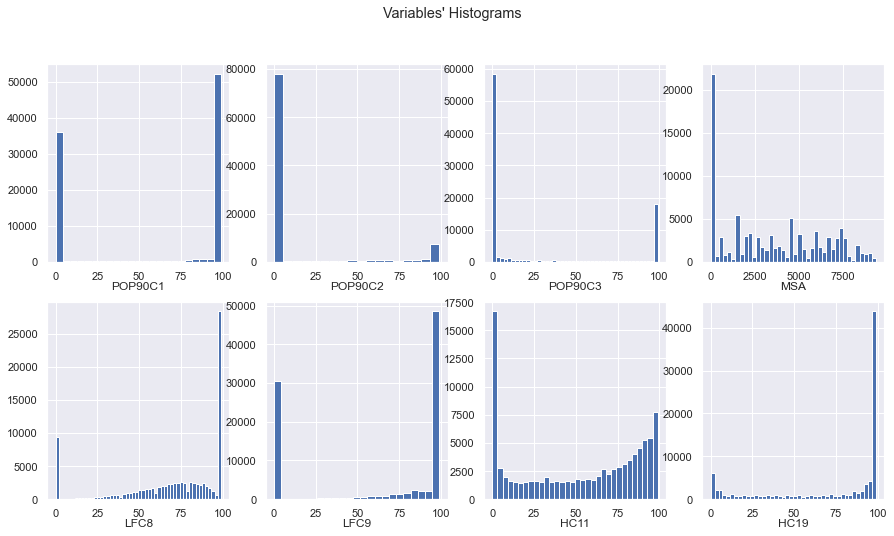

In [30]:
histograms(df,aux2,'auto')

In [31]:
df.shape

(95412, 211)